# USNA Endurance Course Scoring Analysis
##### Captain Coleman Strickland

## Purpose: 
The purpose of this project is to establish an unbiased scoring alrogithm for the USNA endurance course. We will use historic endurance course times construct our scoring matrix, and evaluate our scoring system on test data to determine accuracy. 

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from datascience import *
from scipy import stats
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy.stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

### Data Upload
Data is contained inside of a .csv file and dates back to 2018. Overview of the data specifics are provided below:

| <p align="center"> Column  |   Description  |
|----------|-------------|
| <p align="center">***Cat*** |  Categorical variable representing old/new data. Old: Historic (2018-2020), New: Fall 2021|
|<p align="center">  ***Gender*** |   Categorical variable representing gender: Male (M) and Female (F) |
|<p align="center">  ***Time*** |   Endurance course completion time in seconds |

In [2]:
ecourse = pd.read_csv("Historic_Times.csv")

ecourse.head()

,Cat,Gender,Time
0,old,M,1156
1,old,M,1165
2,old,M,1166
3,old,M,1172
4,old,M,1185


#### Quantity of observations by gender:

In [3]:
ecourse.groupby(['Cat','Gender']).count()

Time
Cat Gender      
new F         16
    M        180
old F        105
    M        721

#### Descriptive Stats

Mean:

In [4]:
ecourse.groupby(['Cat','Gender']).mean()

Time
Cat Gender             
new F       1828.062500
    M       1430.544444
old F       1748.304762
    M       1452.099861

Median:

In [5]:
ecourse.groupby(['Cat','Gender']).median()

Time
Cat Gender        
new F       1807.0
    M       1416.0
old F       1726.0
    M       1422.0

Standard Deviation: Appears to be a significant difference in variance across the genders

In [6]:
ecourse.groupby(['Cat','Gender']).std()

Time
Cat Gender            
new F       345.170387
    M       168.840155
old F       252.985714
    M       194.279691

## Distribution of Times (Males)
We first check for normality using the Shapiro-Wilk Test. Our p-vlaue is highly significant and we can see from the histogram that the data is right skewed.

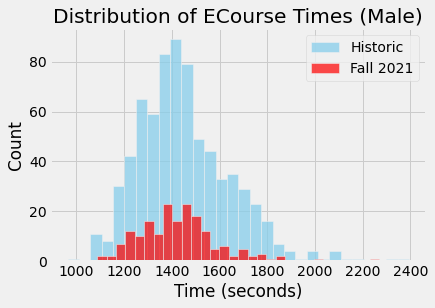

In [7]:
ax = sns.histplot(data=ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='M'], x="Time", color="skyblue", label="Historic", kde=False, bins=30)
sns.histplot(data=ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='M'], x="Time", color="red", label="Fall 2021", kde=False, alpha=.7, bins=30)
ax.set(title='Distribution of ECourse Times (Male)')
plt.xlabel('Time (seconds)')
plt.legend() 
plt.show()

### Are the male old scores and new scores similar?
We perform both an ANOVA and Kruskal-Wallis test to determine if the old male scores and new male scores are similar. The purpose of this detemermination is so we can use the new scores to evaluate our scoring matrix constructed using the old scores. 

We first perform a Shapiro-Wilk test to determine if the times fit a normal distribution - validating one of the assumptions to use the ANOVA test: 

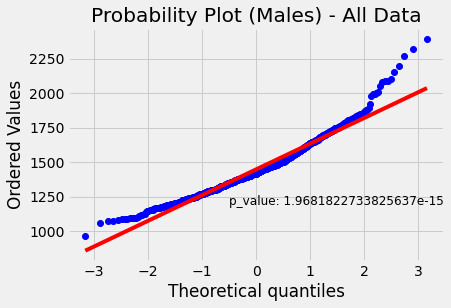

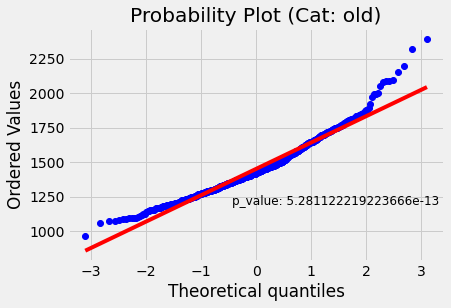

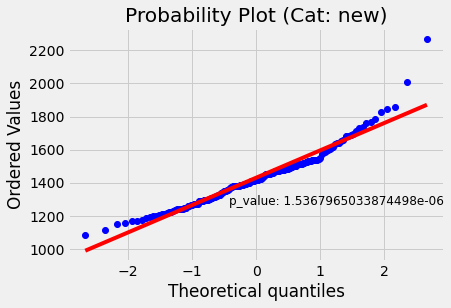

In [8]:
p_values = []

male_times = ecourse[ecourse['Gender']=='M']['Time']
male_mean = np.mean(male_times)
male_sd = np.std(male_times)
shapiro_test = stats.shapiro(male_times)
p_values.append(shapiro_test[-1])

male_times_old = ecourse[ecourse['Gender']=='M'][ecourse['Cat']=='old']['Time']
male_mean = np.mean(male_times_old)
male_sd = np.std(male_times_old)
shapiro_test = stats.shapiro(male_times_old)
p_values.append(shapiro_test[-1])

male_times_new = ecourse[ecourse['Gender']=='M'][ecourse['Cat']=='new']['Time']
male_mean = np.mean(male_times_new)
male_sd = np.std(male_times_new)
shapiro_test = stats.shapiro(male_times_new)
p_values.append(shapiro_test[-1])

flag = True
i = 0
for c in np.arange(0,3):
    if flag:
        stats.probplot(ecourse[ecourse['Gender'] == "M"]['Time'], dist="norm", plot=plt)
        plt.title("Probability Plot (Males) - All Data")
        plt.suptitle("p_value: " + str(p_values[i]), x = .7, y = .3, fontsize = 12)
        plt.show()
        flag = False
    else:
        c = ecourse['Cat'].unique()[i-1]
        stats.probplot(ecourse[ecourse['Gender'] == "M"][ecourse['Cat']==c]['Time'], dist="norm", plot=plt)
        plt.title("Probability Plot (Cat: " +  c + ")")
        plt.suptitle("p_value: " + str(p_values[i]), x = .7, y = .3, fontsize = 12)
        plt.show()
    i += 1

We reject the hypothesis that our data is consistent with a normal distrubition and perform a Kruskal-Wallis test to determine if the categories, old and new, come from the same distribution. 

In [9]:
stats.kruskal(male_times_old, male_times_new)

KruskalResult(statistic=0.9908606369494363, pvalue=0.31953211824939914)

The results of the KW test do not reject the null, and we conclude the data across categories is consistent.

Even though we performed a non-parametric test to evaluate the distribution across the data, we still perform an ANOVA to compare results

In [10]:
male_time_hist = ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='M']['Time']
male_time_hist_mean = np.mean(male_time_hist)
male_time_hist_var = np.var(male_time_hist)
male_time_2021 = ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='M']['Time']
male_time_2021_mean = np.mean(male_time_2021)
male_time_2021_var = np.var(male_time_2021)

male_time_mean_overall = np.mean(ecourse[ecourse['Gender']=='M']['Time'])

SSB = (len(male_time_hist)*(male_time_mean_overall - male_time_hist_mean)**2 + 
       len(male_time_2021)*(male_time_mean_overall - male_time_2021_mean)**2)

SSW = len(male_time_hist)*male_time_hist_var + len(male_time_2021)*male_time_2021_var

dogb = 2-1
dogw = len(male_time_hist)+len(male_time_2021)-2

MSB = SSB/dogb
MSW = SSW/dogw
F_stat = MSB/MSW
print("F-stat:", F_stat)

p = 1-scipy.stats.f.cdf(F_stat, dogb, dogw)

print("P-value:", p)

F-stat: 1.863963003112711
P-value: 0.17250964049987105


Our results from the ANOVA reach the same conclusion: not enough evidence to reject the null, and we assuem the data comes from the same distribution.

## Distribution of Times (Females)
We perform the same set of test across the female times.

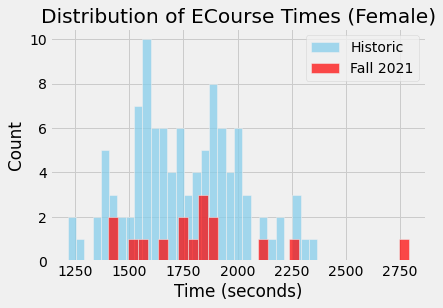

In [11]:
ax = sns.histplot(data=ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='F'], x="Time", color="skyblue", label="Historic", kde=False, bins=30)
sns.histplot(data=ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='F'], x="Time", color="red", label="Fall 2021", kde=False, alpha=.7, bins=30
    )
ax.set(title='Distribution of ECourse Times (Female)')
plt.xlabel('Time (seconds)')
plt.legend() 
plt.show()

### Are the female old scores and new scores similar?
Again, we perform both an ANOVA and Kruskal-Wallis test to determine if the old female scores and new female scores are similar.

Shapiro-Wilk test: 

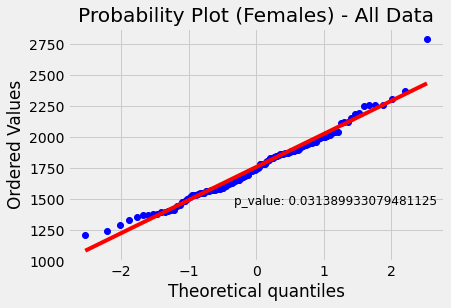

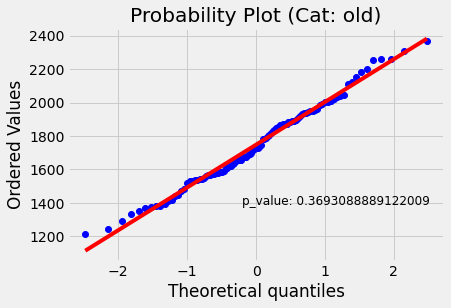

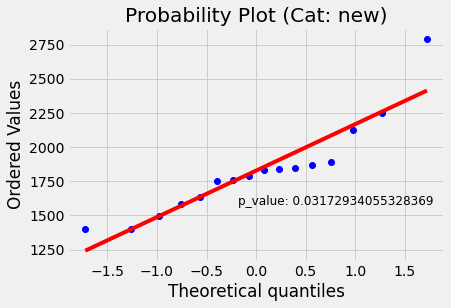

In [12]:
p_values = []

female_times = ecourse[ecourse['Gender']=='F']['Time']
female_mean = np.mean(female_times)
female_sd = np.std(female_times)
shapiro_test = stats.shapiro(female_times)
p_values.append(shapiro_test[-1])

female_times_old = ecourse[ecourse['Gender']=='F'][ecourse['Cat']=='old']['Time']
female_mean = np.mean(female_times_old)
female_sd = np.std(female_times_old)
shapiro_test = stats.shapiro(female_times_old)
p_values.append(shapiro_test[-1])

female_times_new = ecourse[ecourse['Gender']=='F'][ecourse['Cat']=='new']['Time']
female_mean = np.mean(female_times_new)
female_sd = np.std(female_times_new)
shapiro_test = stats.shapiro(female_times_new)
p_values.append(shapiro_test[-1])

flag = True
i = 0
for c in np.arange(0,3):
    if flag:
        stats.probplot(ecourse[ecourse['Gender'] == "F"]['Time'], dist="norm", plot=plt)
        plt.title("Probability Plot (Females) - All Data")
        plt.suptitle("p_value: " + str(p_values[i]), x = .7, y = .3, fontsize = 12)
        plt.show()
        flag = False
    else:
        c = ecourse['Cat'].unique()[i-1]
        stats.probplot(ecourse[ecourse['Gender'] == "F"][ecourse['Cat']==c]['Time'], dist="norm", plot=plt)
        plt.title("Probability Plot (Cat: " +  c + ")")
        plt.suptitle("p_value: " + str(p_values[i]), x = .7, y = .3, fontsize = 12)
        plt.show()
    i += 1

Similar to the male times, we reject the hypothesis that our data is consistent with a normal distrubition and perform a Kruskal-Wallis test to determine if the categories, old and new, come from the same distribution. 

In [13]:
stats.kruskal(female_times_old, female_times_new)

KruskalResult(statistic=0.2868901044930496, pvalue=0.592220351591044)

The results of the KW test do not reject the null, and we conclude the data across categories is consistent.

Finally, we perform an ANOVA test for comparison:

In [14]:
female_time_hist = ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='F']['Time']
female_time_hist_mean = np.mean(female_time_hist)
female_time_hist_var = np.var(female_time_hist)
female_time_2021 = ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='F']['Time']
female_time_2021_mean = np.mean(female_time_2021)
female_time_2021_var = np.var(female_time_2021)

female_time_mean_overall = np.mean(ecourse[ecourse['Gender']=='F']['Time'])

SSB = (len(female_time_hist)*(female_time_mean_overall - female_time_hist_mean)**2 + 
       len(female_time_2021)*(female_time_mean_overall - female_time_2021_mean)**2)

SSW = len(female_time_hist)*female_time_hist_var + len(female_time_2021)*female_time_2021_var

dogb = 2-1
dogw = len(female_time_hist)+len(female_time_2021)-2

MSB = SSB/dogb
MSW = SSW/dogw
F_stat = MSB/MSW
print("F-stat:", F_stat)

p = 1-scipy.stats.f.cdf(F_stat, dogb, dogw)

print("P-value:", p)

F-stat: 1.2448101411928854
P-value: 0.26679398738478954


Our results from the ANOVA reach the same conclusion: not enough evidence to reject the null, and we assume the data comes from the same distribution.

## Scoring Algorithm
We construct our scoring system using "old" categorized data. The scoring system is set to a maximum score of 100 points and minimum score of 60 points – allowing for an average score of 80. We use the 10th percentile, 50th
percentile, and 90th percentile as the method to establish the maximum, average (in this case median), and
minimum score respectively. For example, a male participant who runs the endurance course in 23:46
(median completion time for category "old"), should achieve a score around 80 points.
Next, we create a 1-point decrement system to allow for a distributed point reduction based on specified
completion times. To establish the 1-point decrement system, we use the middle 80% of completion times
divided by the difference between the maximum and minimum points that can be achieved (40 points). This calculation
results in a 1-point reduction for every next even percentile. For example, the 12th percentile earns a 99, the
14th percentile a 98, etc. Because the scoring table must be objective and not relative to percentiles in a
specified data set, we calculate the average time difference between the even percentiles and use the time
difference to determine when to apply the 1-point decrement.

#### Males Scoring Table
The 1-point decrement is applied every 10 seconds for males, the justification for this value is annotated in the code below.

In [15]:
male_time_hist = ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='M']['Time']
male_time_2021 = ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='M']['Time']


time_diff = []
p1 = stats.scoreatpercentile(male_time_hist,10)
for p in np.arange(10,92, 2):  #iterate through even percentiles
    if p>=12:
        time_diff.append(stats.scoreatpercentile(male_time_hist, p) - p1)
        p1 = stats.scoreatpercentile(male_time_hist, p)
              
print("Mean Time Difference (sec): ", np.mean(time_diff), "-> set to 10 seconds for easier scoring")     

Mean Time Difference (sec):  12.075 -> set to 10 seconds for easier scoring


In [16]:
print("Max Score Time: \t", stats.scoreatpercentile(male_time_hist,10), "seconds", "(approximately 20:30 minutes)")
print("Median Score Time: \t", stats.scoreatpercentile(male_time_hist,50), "seconds", "(approximately 23:50 minutes)")
print("Min Score Time: \t", stats.scoreatpercentile(male_time_hist,90), "seconds", "(approximately 28:30 minutes)")

Max Score Time: 	 1231.0 seconds (approximately 20:30 minutes)
Median Score Time: 	 1422.0 seconds (approximately 23:50 minutes)
Min Score Time: 	 1714.0 seconds (approximately 28:30 minutes)


Create scoring table based on the values from above.

In [17]:
max_score = 20*60+30  # 21:30 minutes
dec  = 10             # 10 seconds
min_score = 28*60+30  # 28:30 minutes
(max_score-min_score)/dec

score_df = pd.DataFrame(columns=['Score (%)', 'Time (male)'])

score_list = [100]
time_list = [max_score]
flag=True
counter = 0

while flag:

    time_list.append(time_list[counter]+dec)
    score_list.append(score_list[counter]-1)
    
    if score_list[counter]<=0: #change for setting minimum at 60
        flag = False
    counter+=1
score_df['Time (male)'] = time_list
score_df['Score (%)'] = score_list

time = []
for index, row in score_df.iterrows():
    minute = np.round(np.floor(row['Time (male)']/60),0)
    seconds = np.mod(row['Time (male)'], 60)
    time.append(f"{minute:.0f}:{seconds:.0f}")
    
score_df['Time (male)'] = time

#### Female Scoring Table
Females earn a 1-point deduction every 15 seconds based on the variance across the female times. We perform a levene and F-test to provide statistical evidence to support rejecting the null hypothesis: the variance across the times for males and females is homogenous.

In [18]:
m = ecourse[ecourse['Gender']=='M']['Time']
m_var = np.var(m)

f = ecourse[ecourse['Gender']=='F']['Time']
f_var = np.var(f)

F = m_var / f_var
alpha = 0.05 #Or whatever you want your alpha to be.
df1 = len(m) - 1
df2 = len(f) - 1
p_value = scipy.stats.f.cdf(F, df1, df2)
print("F-test p_value:", p_value)

from scipy.stats import levene
stat, p = levene(m, f)
print('Levene Test p-value:', p)

F-test p_value: 3.7874866335775345e-08
Levene Test p-value: 6.256980338284763e-08


In [19]:
female_time_hist = ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='F']['Time']
female_time_2021 = ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='F']['Time']


time_diff = []
p1 = stats.scoreatpercentile(female_time_hist,10)
for p in np.arange(10,92, 2): #iterate through even percentiles
    if p>=12:
        time_diff.append(stats.scoreatpercentile(female_time_hist,p) - p1)
        p1 = stats.scoreatpercentile(female_time_hist, p)
              
print("Mean Time Difference (sec): ", np.mean(time_diff), "-> set to 15 seconds for easier scoring")    

Mean Time Difference (sec):  15.669999999999993 -> set to 15 seconds for easier scoring


In [20]:
print("Max Score Time: \t", stats.scoreatpercentile(female_time_hist,10), "seconds", "(approximately 23:30 minutes)")
print("Median Score Time: \t", stats.scoreatpercentile(female_time_hist,50), "seconds", "(approximately 28:45 minutes)")
print("Min Score Time: \t", stats.scoreatpercentile(female_time_hist,90), "seconds", "(approximately 34:00 minutes)")

Max Score Time: 	 1414.4 seconds (approximately 23:30 minutes)
Median Score Time: 	 1726.0 seconds (approximately 28:45 minutes)
Min Score Time: 	 2041.1999999999998 seconds (approximately 34:00 minutes)


Create scoring table based on values from above: 

In [21]:
max_score = 23*60+30 # 23:30 minutes
dec  = 15            # 10 seconds
min_score = 34*60    # 34 minutes
(max_score-min_score)/dec

#score_df = pd.DataFrame(columns=['Score (%)', 'Time (male)'])

score_list = [100]
time_list = [max_score]
flag=True
counter = 0

while flag:

    time_list.append(time_list[counter]+dec)
    score_list.append(score_list[counter]-1)
    
    if score_list[counter]<=0:
        flag = False
    counter+=1
score_df['Time (female)'] = time_list
score_df['Score (%)'] = score_list

time = []
for index, row in score_df.iterrows():
    minute = np.round(np.floor(row['Time (female)']/60),0)
    seconds = np.mod(row['Time (female)'], 60)
    time.append(str(f"{minute:.0f}:{seconds:.0f}"))
    
score_df['Time (female)'] = time

### Scoring Table
The scoring table below is the final output from the algorithm described. 

In [22]:
score_df

,Score (%),Time (male),Time (female)
0,100,20:30,23:30
1,99,20:40,23:45
2,98,20:50,24:0
3,97,21:0,24:15
4,96,21:10,24:30
...,...,...,...
97,3,36:40,47:45
98,2,36:50,48:0
99,1,37:0,48:15
100,0,37:10,48:30


## Evaluate Scoring Table 
Our final task is to apply the scoring table on the "new" data provided. The results are compared across both the "old" and "new" categories to validate the scoring table is accurate and valid.

#### Males
Scoring all data based on our scoring matrix, we see the results are consistent across the two categories "old" and "new". We provide metrics for each, along with a histogram to visualize how the scoring results compare. 

In [23]:
male_times = ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='M']['Time']

male_df = pd.DataFrame(columns=['Score (%)', 'Time (male)'])
male_scores = []
male_t = []
for t in male_times:
    for index, row in score_df.iterrows():
        minutes = int(str(row['Time (male)'][0]+row['Time (male)'][1]))
        try: 
            seconds =  int(str(row['Time (male)'][3]+row['Time (male)'][4]))
        except: 
            seconds = int(str(row['Time (male)'][3]))

        if t > (minutes*60+seconds):
            score = row['Score (%)']
        else:
            break
    male_t.append(t)
    male_scores.append(score)

male_df['Score (%)'] = male_scores
male_df['Time (male)'] = male_t

male_df_new = male_df

In [24]:
print(len(male_df[male_df['Score (%)']>90])/len(male_df['Score (%)']))  #shooting for 20%

print(len(male_df[male_df['Score (%)']<=60])/len(male_df['Score (%)']))

0.24444444444444444
0.12777777777777777


In [25]:
p90 = stats.scoreatpercentile(male_df['Score (%)'], 90)
p50 = stats.scoreatpercentile(male_df['Score (%)'], 50)
p10 = stats.scoreatpercentile(male_df['Score (%)'], 10)
print(p90, p50, p10)

95.1 81.0 57.7


In [26]:
male_times = ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='M']['Time']

male_df = pd.DataFrame(columns=['Score (%)', 'Time (male)'])
male_scores = []
male_t = []
for t in male_times:
    for index, row in score_df.iterrows():
        minutes = int(str(row['Time (male)'][0]+row['Time (male)'][1]))
        try: 
            seconds =  int(str(row['Time (male)'][3]+row['Time (male)'][4]))
        except: 
            seconds = int(str(row['Time (male)'][3]))

        if t > (minutes*60+seconds):
            score = row['Score (%)']
        else:
            break
    male_t.append(t)
    male_scores.append(score)

male_df['Score (%)'] = male_scores
male_df['Time (male)'] = male_t

In [27]:
print(len(male_df[male_df['Score (%)']>90])/len(male_df['Score (%)']))  #shooting for 20%

print(len(male_df[male_df['Score (%)']<=60])/len(male_df['Score (%)']))

0.20249653259361997
0.18030513176144244


In [28]:
p90 = stats.scoreatpercentile(male_df['Score (%)'], 90)
p50 = stats.scoreatpercentile(male_df['Score (%)'], 50)
p10 = stats.scoreatpercentile(male_df['Score (%)'], 10)
print(p90, p50, p10)

95.0 79.0 52.0


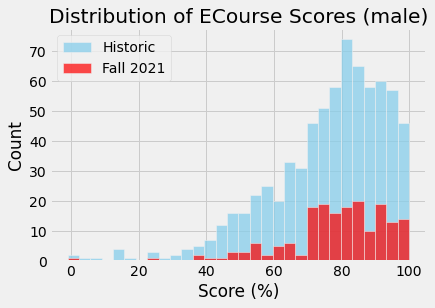

In [29]:
ax = sns.histplot(data=male_df, x="Score (%)", color="skyblue", label="Historic", kde=False, bins=30)
sns.histplot(data=male_df_new, x="Score (%)", color="red", label="Fall 2021", kde=False, alpha=.7, bins=30)
ax.set(title='Distribution of ECourse Scores (male)')
plt.xlabel('Score (%)')
plt.legend() 
plt.show()

#### Females
Similarly, we see consistency with the female scores as well, and provide metrics below.

In [30]:
female_times= ecourse[ecourse['Cat']=='new'][ecourse['Gender']=='F'][ecourse['Time']<2700]['Time']
#female_times = np.random.choice(list(female_times),replace = True, size = 105)
female_df = pd.DataFrame(columns=['Score (%)', 'Time (female)'])
female_scores = []
female_t = []
for t in female_times:
    for index, row in score_df.iterrows():
        minutes = int(str(row['Time (female)'][0]+row['Time (female)'][1]))
        try: 
            seconds =  int(str(row['Time (female)'][3]+row['Time (female)'][4]))
        except: 
            seconds = int(str(row['Time (female)'][3]))

        if t > (minutes*60+seconds):
            score = row['Score (%)']
        else:
            break
    female_t.append(t)
    female_scores.append(score)

female_df['Score (%)'] = female_scores
female_df['Time (female)'] = female_t

female_df_new = female_df

In [31]:
print(len(female_df[female_df['Score (%)']>90])/len(female_df['Score (%)']))  #shooting for 20%

print(len(female_df[female_df['Score (%)']<=60])/len(female_df['Score (%)']))

0.06666666666666667
0.13333333333333333


In [32]:
p90 = stats.scoreatpercentile(female_df['Score (%)'], 90)
p50 = stats.scoreatpercentile(female_df['Score (%)'], 50)
p10 = stats.scoreatpercentile(female_df['Score (%)'], 10)
print(p90, p50, p10)

87.80000000000001 76.0 59.0


In [33]:
female_times= ecourse[ecourse['Cat']=='old'][ecourse['Gender']=='F']['Time']

female_df = pd.DataFrame(columns=['Score (%)', 'Time (female)'])
female_scores = []
female_t = []
for t in female_times:
    for index, row in score_df.iterrows():
        minutes = int(str(row['Time (female)'][0]+row['Time (female)'][1]))
        try: 
            seconds =  int(str(row['Time (female)'][3]+row['Time (female)'][4]))
        except: 
            seconds = int(str(row['Time (female)'][3]))

        if t > (minutes*60+seconds):
            score = row['Score (%)']
        else:
            break
    female_t.append(t)
    female_scores.append(score)

female_df['Score (%)'] = female_scores
female_df['Time (female)'] = female_t

In [34]:
print(len(female_df[female_df['Score (%)']>90])/len(female_df['Score (%)']))  #shooting for 20%

print(len(female_df[female_df['Score (%)']<=60])/len(female_df['Score (%)']))

0.1619047619047619
0.13333333333333333


In [35]:
p90 = stats.scoreatpercentile(female_df['Score (%)'], 90)
p50 = stats.scoreatpercentile(female_df['Score (%)'], 50)
p10 = stats.scoreatpercentile(female_df['Score (%)'], 10)
print(p90, p50, p10)

92.0 78.0 58.400000000000006


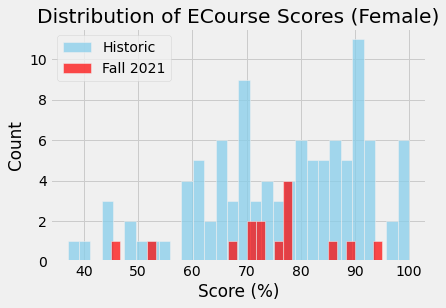

In [36]:
ax = sns.histplot(data=female_df, x="Score (%)", color="skyblue", label="Historic", kde=False, bins=30)
sns.histplot(data=female_df_new, x="Score (%)", color="red", label="Fall 2021", kde=False, alpha=.7, bins=30)
ax.set(title='Distribution of ECourse Scores (Female)')
plt.xlabel('Score (%)')
plt.legend() 
plt.show()

## Conclusion
We set out to provide a endurance course scoring matrix which is unbiased and consistent. The scoring matrix is based on using historical data to construct a 1-point decrement system based on percentiles. We manipulate the times for applying the 1-point decrement based on gender (males: every 10 seconds, females: every 15 seconds), and this decision is based performing an appropriate statistical test for justification.